In [18]:
from os.path import join
import numpy as np
import nibabel as nib
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
import sys
from time import time
import pandas as pd

sys.path.append("/home/agajan/DeepMRI")
from deepmri import dsutils, visutils  # noqa: E402

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# settings
SUBJ_ID = "784565"
DATA_DIR = "/home/agajan/experiment_DiffusionMRI/tractseg_data/"
DATA_PATH = join(DATA_DIR, SUBJ_ID, "data.nii.gz")
MASK_PATH = join(DATA_DIR, SUBJ_ID, "nodif_brain_mask.nii.gz")
TRACT_MASKS_PTH = join(DATA_DIR, SUBJ_ID, "tract_masks", "tract_masks.nii.gz")
LABELS = ["Other", "CG", "CST", "FX", "CC"]

In [3]:
# load data
DATA = nib.load(DATA_PATH).get_data()
MASK = nib.load(MASK_PATH).get_data()
TRACT_MASKS = nib.load(TRACT_MASKS_PTH).get_data()
TRACT_MASKS = TRACT_MASKS[:, :, :, 1:]  # remove background class
SAVE_PATH = join(DATA_DIR, SUBJ_ID, "pca_stats.npz")
unnorm_stats = np.load(join(DATA_DIR, SUBJ_ID, "pca_stats_unnorm.npz"))
norm_stats = np.load(join(DATA_DIR, SUBJ_ID, "pca_stats_norm.npz"))

[]

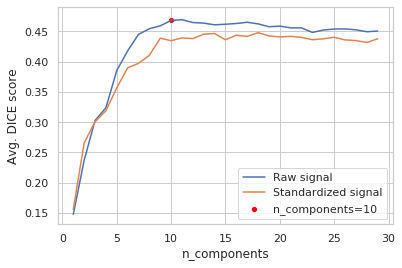

In [70]:
sns.set(style="whitegrid")
sns.lineplot(unnorm_stats["n_components"], unnorm_stats["scores"], label="Raw signal")
sns.lineplot(norm_stats["n_components"], norm_stats["scores"], label="Standardized signal")
sns.scatterplot([10], unnorm_stats["scores"][10], color='red', label="n_components=10")
plt.xlabel("n_components")
plt.ylabel("Avg. DICE score")
# plt.xlim((0, 30))
# plt.title("Average DICE score using first k principal components.")
plt.plot()

In [5]:
_, pca_unnorm = dsutils.make_pca_volume(DATA, MASK, 288, normalize=False)
_, pca_norm = dsutils.make_pca_volume(DATA, MASK, 288, normalize=True)

Making data matrix
Performing PCA.
Making features volume.
Making data matrix
Normalizing.
Performing PCA.
Making features volume.


[]

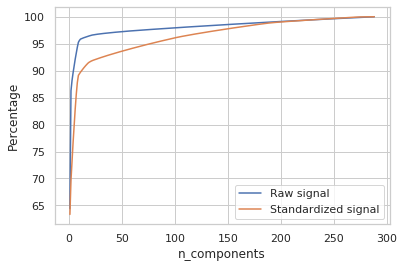

In [66]:
x = list(range(1, 289))
nc = 288
y_unnorm = [sum(pca_unnorm.explained_variance_ratio_[:i])*100 for i in range(1, 289)]
y_norm = [sum(pca_norm.explained_variance_ratio_[:i])*100 for i in range(1, 289)]
sns.lineplot(x[:nc], y_unnorm[:nc], label="Raw signal")
sns.lineplot(x[:nc], y_norm[:nc], label="Standardized signal")
plt.ylabel("Percentage")
plt.xlabel("n_components")
# plt.title("Explained variance by first k principal components")
plt.plot()

In [81]:
np.argmax(unnorm_stats["scores"]), unnorm_stats["scores"][10]

(10, 0.4694207387643168)

In [82]:
n_components = 2
normalize = False

print("Making data matrix")

coords = []
features = []
for x in range(145):
    for y in range(174):
        for z in range(145):
            if MASK[x, y, z]:
                coords.append((x, y, z))
                features.append(DATA[x, y, z, :])

if normalize:
    print("Normalizing.")
    features = StandardScaler().fit_transform(features)

print("Performing PCA.")
pca = PCA(n_components=n_components, random_state=0)
features_reduced = pca.fit_transform(features)

Making data matrix
Performing PCA.


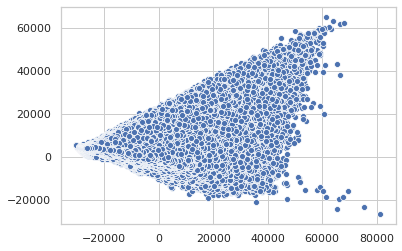

In [85]:
x = features_reduced[:, 0]
y = features_reduced[:, 1]
sns.scatterplot(x, y)

Making data matrix
Normalizing.
Performing PCA.


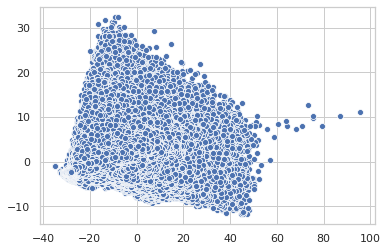

In [86]:
n_components = 2
normalize = True

print("Making data matrix")

coords = []
features = []
for x in range(145):
    for y in range(174):
        for z in range(145):
            if MASK[x, y, z]:
                coords.append((x, y, z))
                features.append(DATA[x, y, z, :])

if normalize:
    print("Normalizing.")
    features = StandardScaler().fit_transform(features)

print("Performing PCA.")
pca = PCA(n_components=n_components, random_state=0)
features_reduced = pca.fit_transform(features)

x = features_reduced[:, 0]
y = features_reduced[:, 1]
sns.scatterplot(x, y)

Text(0.5, 1.0, 'PCA on raw diffusion signal')

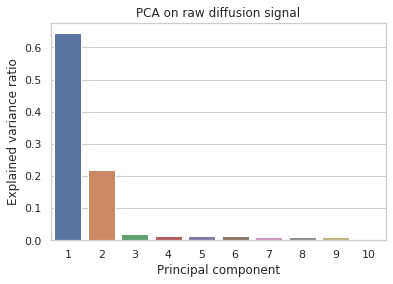

In [100]:
sns.barplot(list(range(1, 11)), pca_unnorm.explained_variance_ratio_[:10])
plt.xlabel("Principal component")
plt.ylabel("Explained variance ratio")
plt.title("PCA on raw diffusion signal")

Text(0.5, 1.0, 'PCA on standardized diffusion signal')

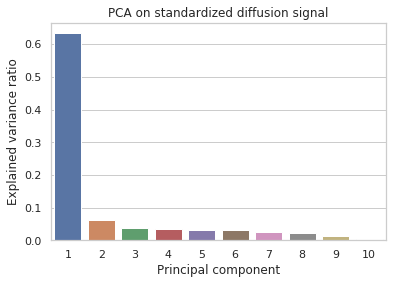

In [101]:
sns.barplot(list(range(1, 11)), pca_norm.explained_variance_ratio_[:10])
plt.xlabel("Principal component")
plt.ylabel("Explained variance ratio")
plt.title("PCA on standardized diffusion signal")